# Outlier detection in the forest-dataset.

We'll be using the [covertype](https://scikit-learn.org/stable/datasets/real_world.html#covtype-dataset) dataset from sklearn for this example.

## Load data

First load the data!

In [14]:
from sklearn.datasets import fetch_covtype

# Load the Covertype dataset
data = fetch_covtype(as_frame=True)
X = data.data
y = data.target

print(X.head())
print(y.head())

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2          234.0           238.0   

This dataset is pretty large. Not only in rows, 500k, but also in dimensionality (nr of columns): 54. It'll allow us to do some serious searching and cleaning. (The "head"-output is also not very pretty because of that).

SKlearn was really nice in giving us the data pre-split, with X and Y separately. But we want to work with outliers, meaning we'll probably delete rows at some point. Then it'll be better to have one dataframe with both X and y, where the y-column is called "target". We can still split them later on.

(It also has the added advantage that we can randomly delete rows in "df" and restore them by copying "X" and "y" again.)

In [15]:
#DELETE
df = X.copy()
df['target'] = y

## Data exploration

Always start with exploration. First, get the info on X.

In [16]:
#DELETE
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

53 fields, all float64 (good for models!) and no null-values. Promising. But what graphs works best to see if any outliers are present? The boxplot. Everything outside of the whiskers is outside of 3*IQR and can safely be deleted.

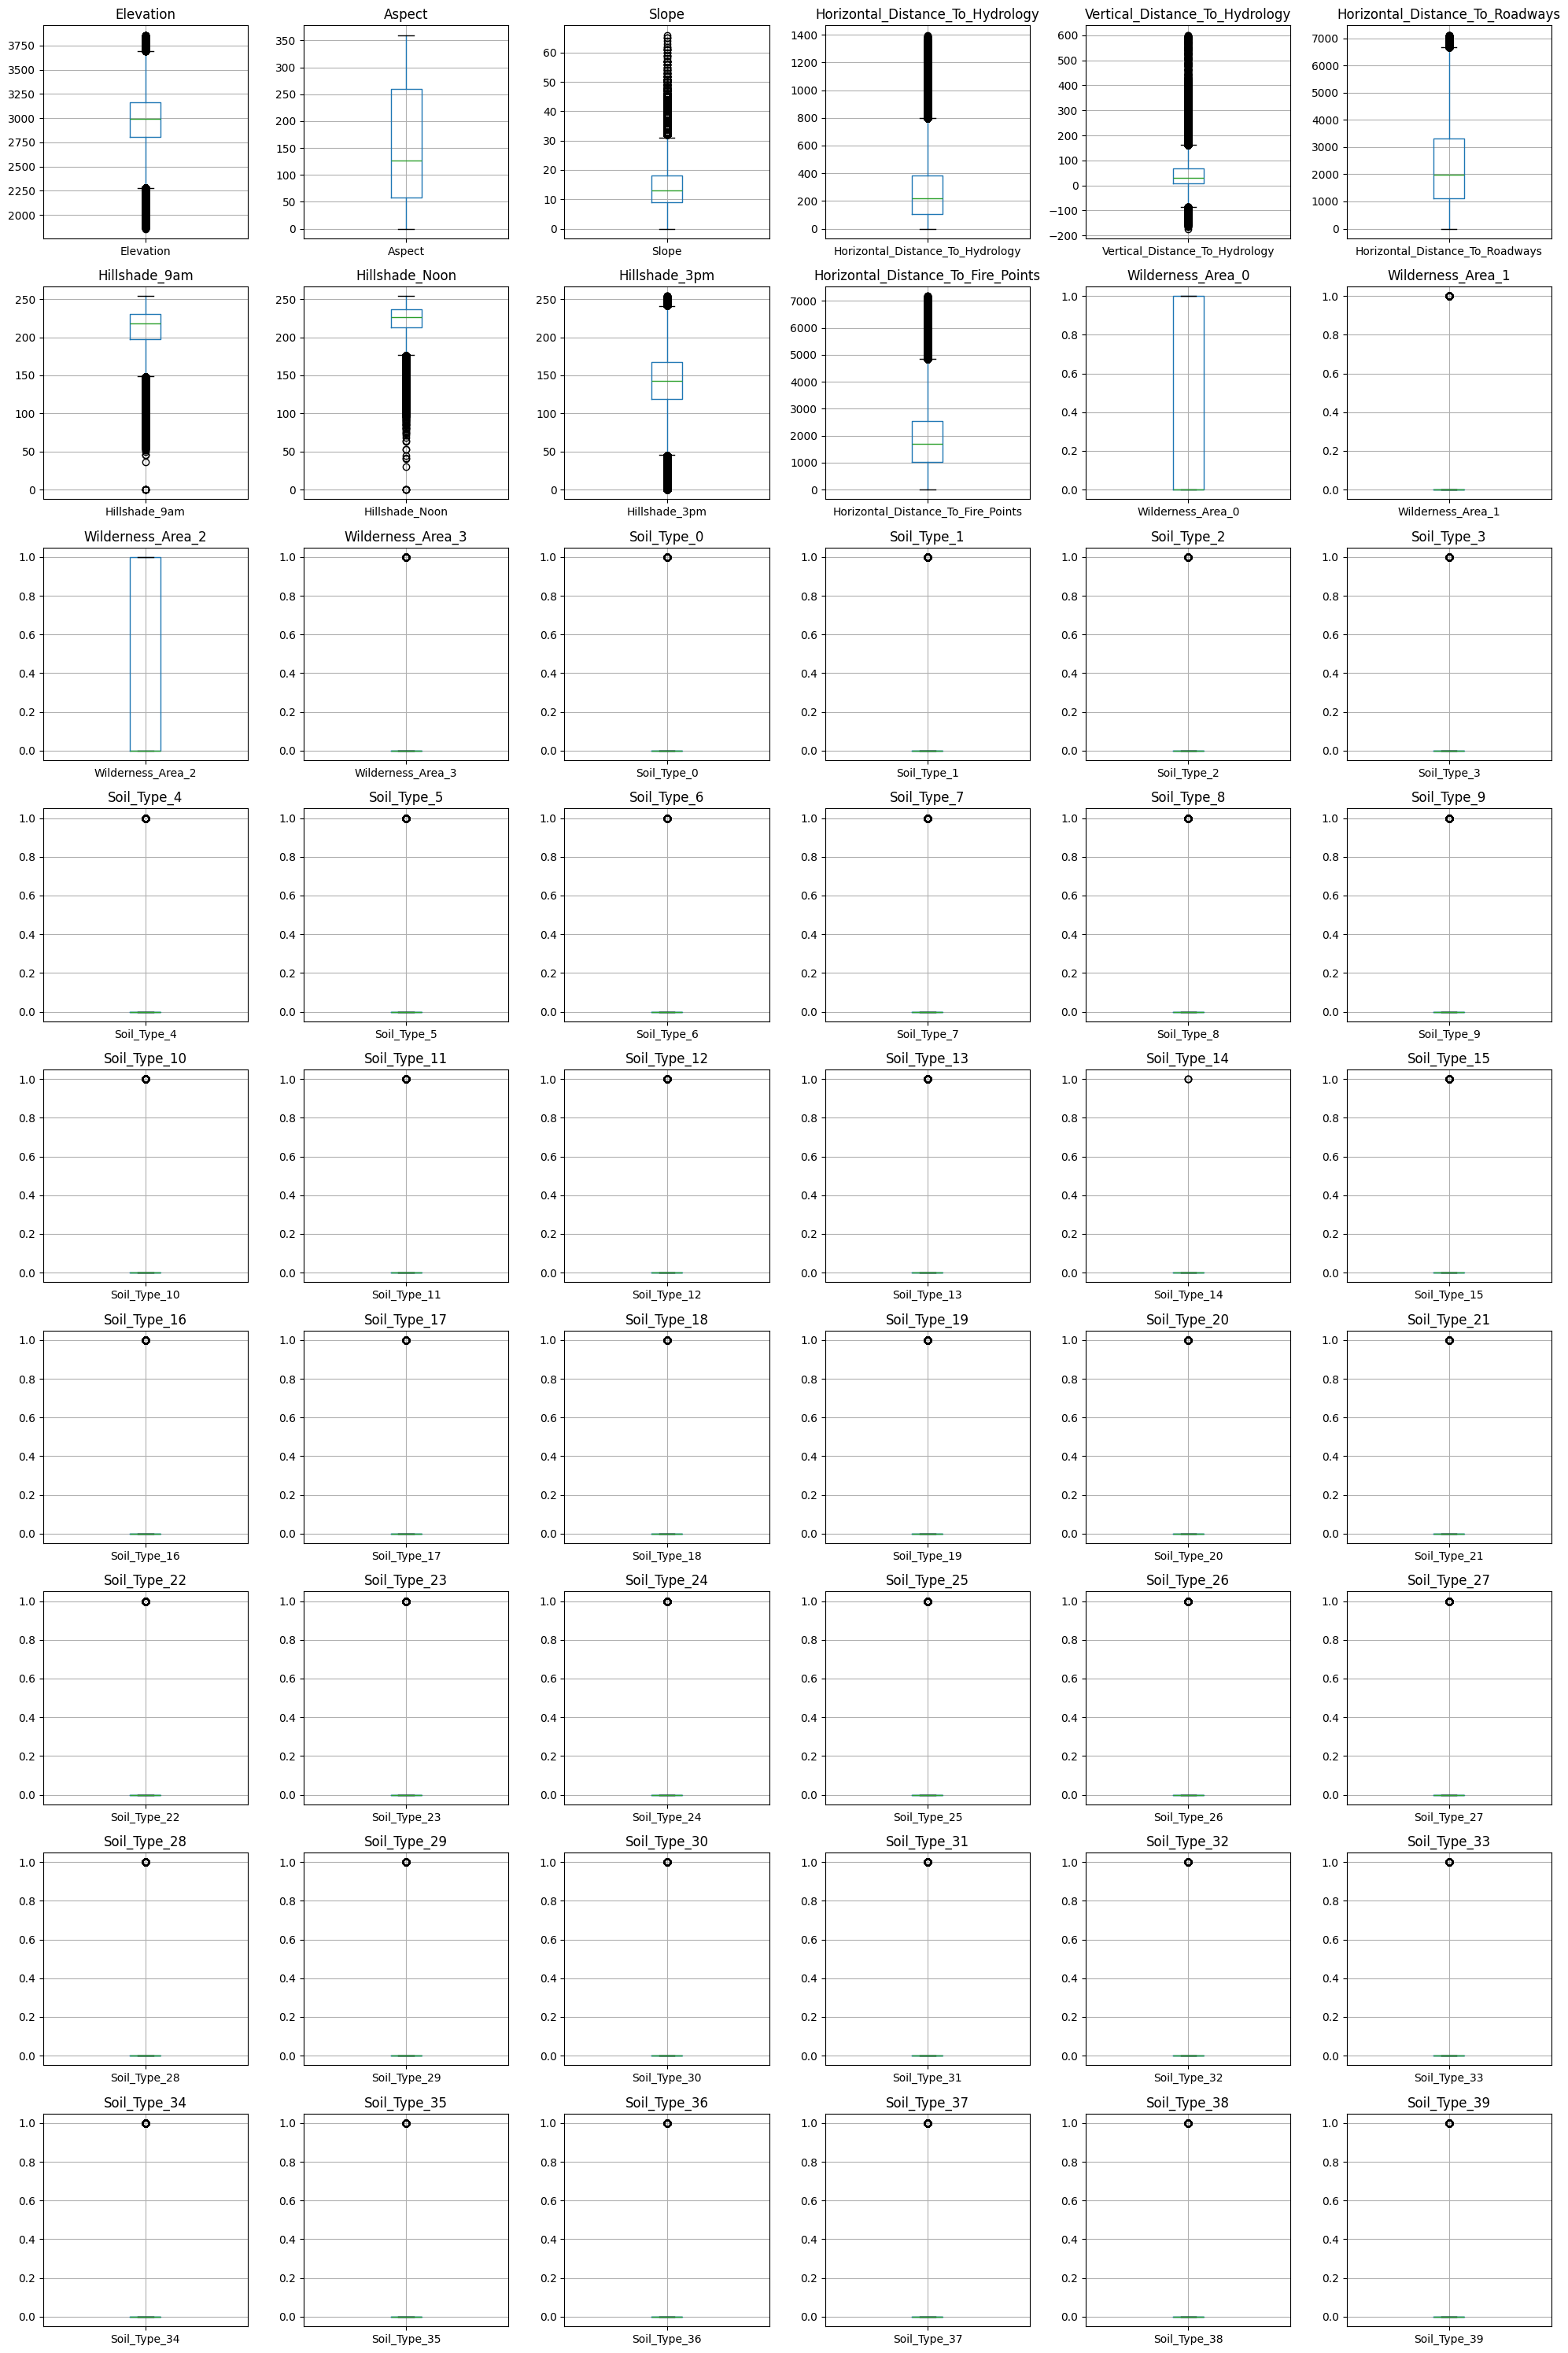

In [17]:
#DELETE
import matplotlib.pyplot as plt

# Set up the figure size
fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(20, 30))
axes = axes.flatten()

# Plot each column as a boxplot
for i, column in enumerate(X.columns):
    if i < len(axes):  # Ensure we don't exceed the number of axes
        X.boxplot(column=column, ax=axes[i])
        axes[i].set_title(column)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

The first couple of fields look normal, bet when starting with the soil types it's obvious that something is going on.

![](../files/2025-05-12-21-09-12.png)

This graphs shows all values are around 0, but there is one values (or maybe a couple of values, but not a lot of them) that is 1 and these mess up our graph. With any luck it's the same (couple of) row(s) that have these values.

Show all rows that have a value of 1 in "soil_30".

In [18]:
#DELETE
rows_with_soil_30 = X[X['Soil_Type_30'] == 1]
print(rows_with_soil_30)

        Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
1652       2685.0     8.0   10.0                             255.0   
1817       2675.0    42.0   13.0                              60.0   
2171       2917.0   130.0    4.0                             150.0   
2194       2769.0     6.0   12.0                             162.0   
2207       2895.0   122.0   14.0                             150.0   
...           ...     ...    ...                               ...   
546163     3117.0   196.0   18.0                             870.0   
546164     3120.0   196.0   18.0                             892.0   
546296     3106.0   195.0   13.0                             828.0   
546297     3108.0   196.0   15.0                             850.0   
546440     3101.0   188.0    8.0                             807.0   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
1652                              93.0                            891.0   
1817     

No luck. But strangely enough the other soils are all "0". And we said the other values were around 0, but they could have also been exactly 0.

How many different values are stored in the soil-columns (and the other columns)?

In [19]:
#DELETE
unique_values_per_column = X.nunique()
print(unique_values_per_column)

Elevation                             1978
Aspect                                 361
Slope                                   67
Horizontal_Distance_To_Hydrology       551
Vertical_Distance_To_Hydrology         700
Horizontal_Distance_To_Roadways       5785
Hillshade_9am                          207
Hillshade_Noon                         185
Hillshade_3pm                          255
Horizontal_Distance_To_Fire_Points    5827
Wilderness_Area_0                        2
Wilderness_Area_1                        2
Wilderness_Area_2                        2
Wilderness_Area_3                        2
Soil_Type_0                              2
Soil_Type_1                              2
Soil_Type_2                              2
Soil_Type_3                              2
Soil_Type_4                              2
Soil_Type_5                              2
Soil_Type_6                              2
Soil_Type_7                              2
Soil_Type_8                              2
Soil_Type_9

Found it! "Wilderniss area" and "soil" are simply 1 or 0. We won't find any outliers there. Let's refocus our attention to the other columns and draw the box_plots again.

Draw box plots for the first 10 columns.

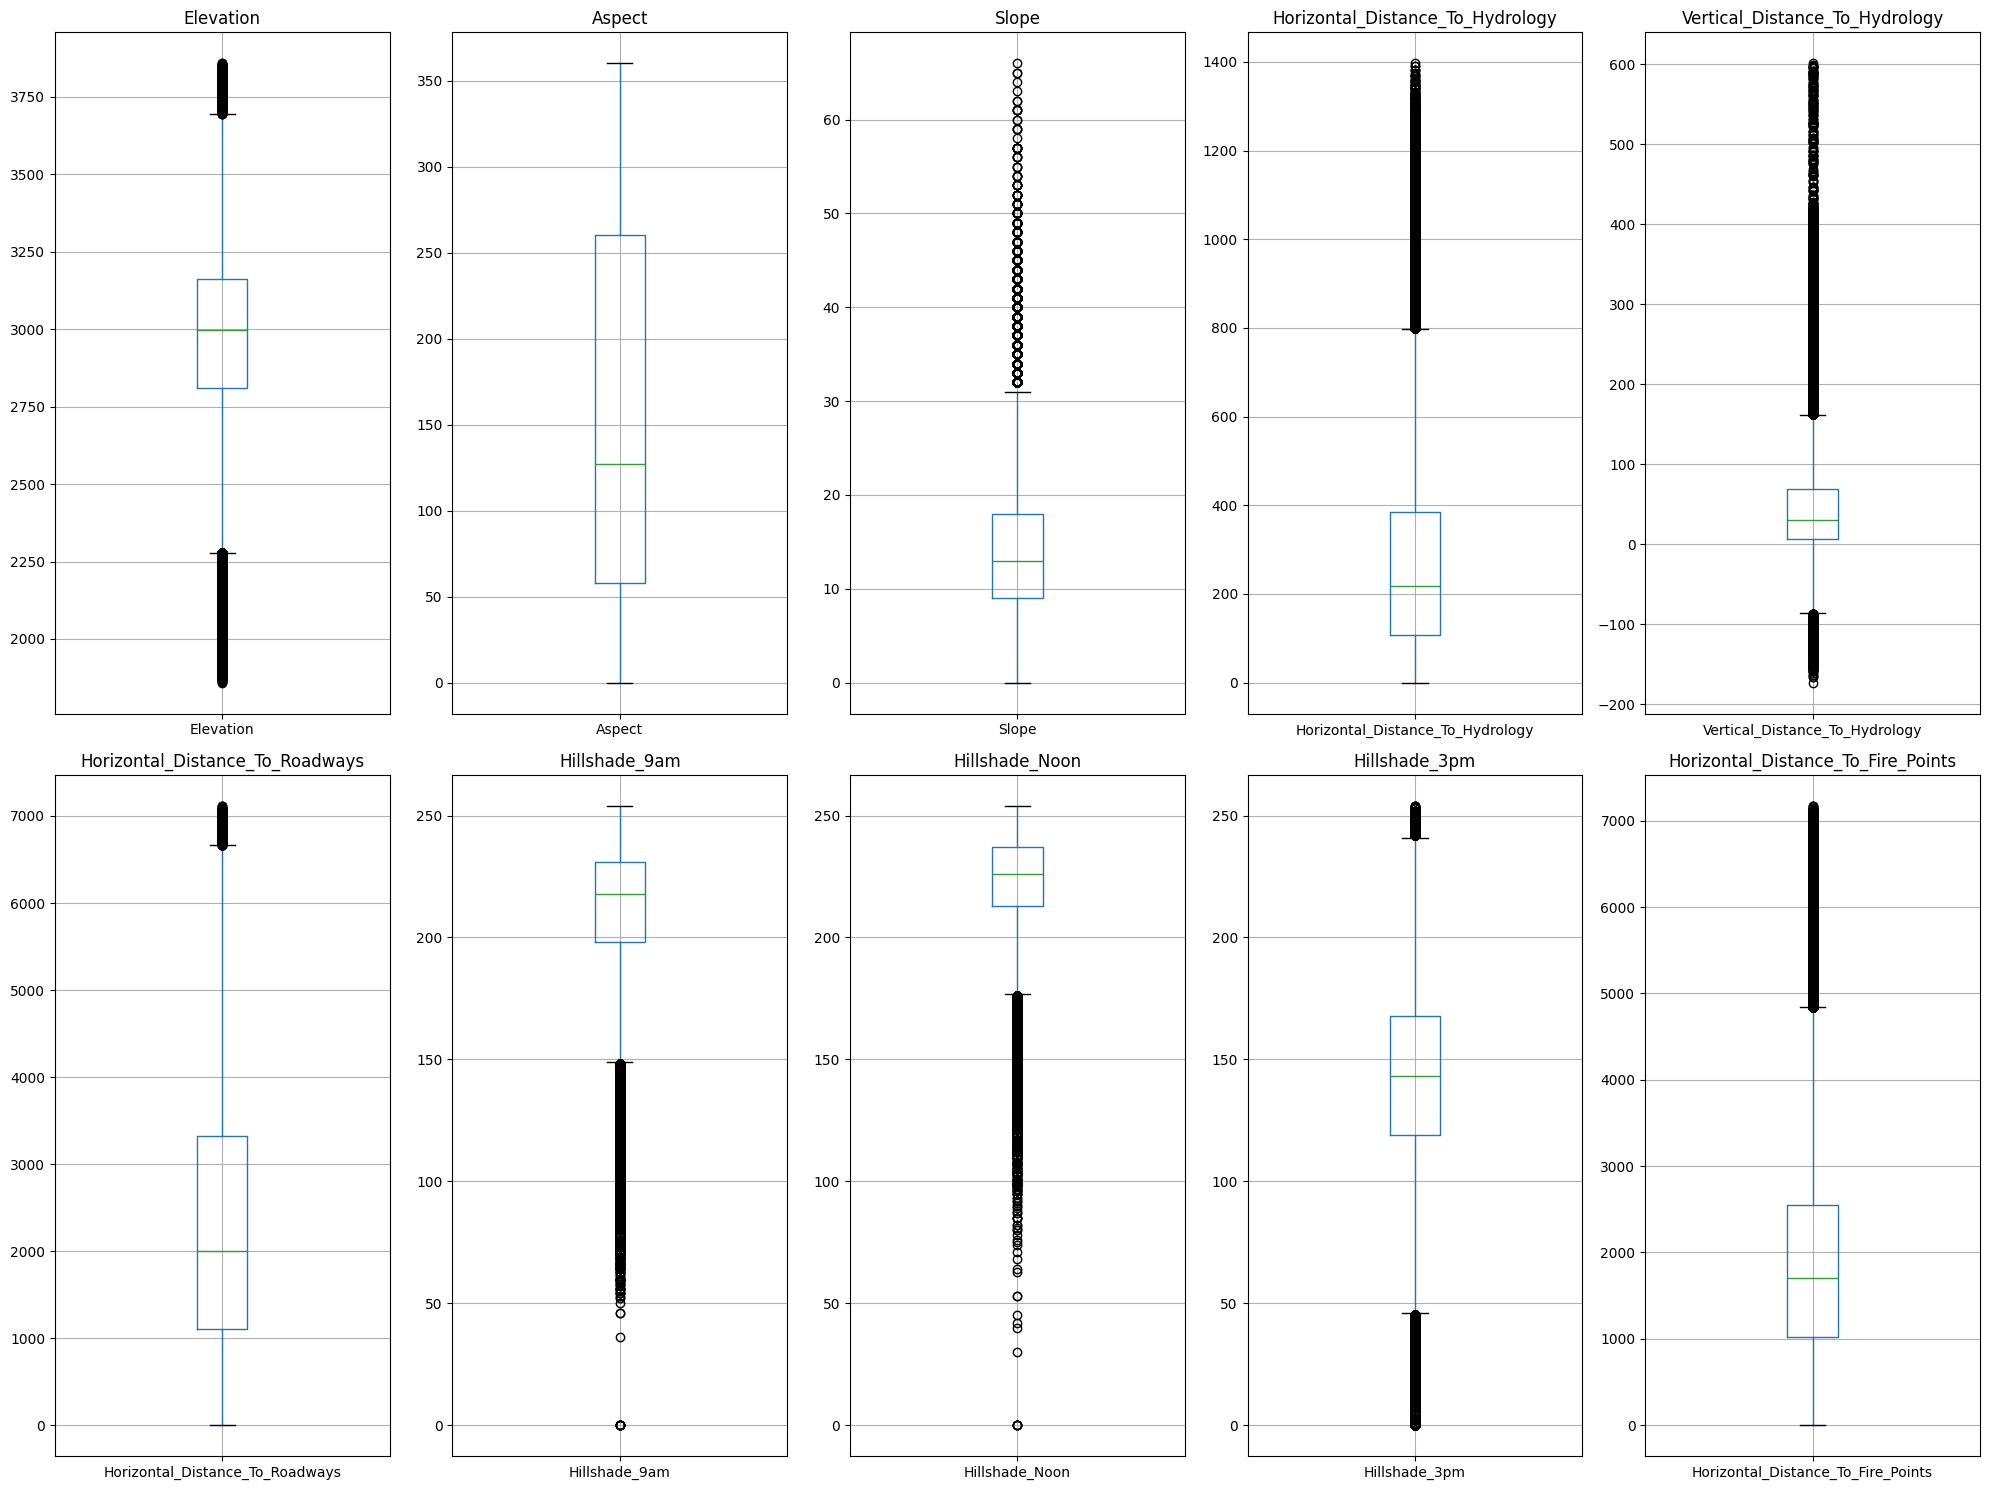

In [20]:
#DELETE
import matplotlib.pyplot as plt

# Set up the figure size
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Plot each column as a boxplot
for i, column in enumerate(X.columns[:10]):
    if i < len(axes):  # Ensure we don't exceed the number of axes
        X.boxplot(column=column, ax=axes[i])
        axes[i].set_title(column)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Aspect is fine (some skewing, tail to the right) but the others all have outliers.

## Dealing with outliers

Deleting all rows with outliers is one option, but not always the best. It has it's downsides:

The outliers can be informative: There are some patches of wood where very special trees grow. These only grow on places where there is no (or very little) Hillshade_9am. By deleting the outliers in that column, we'll be deleting the entire type of tree.

**You risk introducing bias**: by deleting all data where the horizontal_distance_to_fire_points is large, you deleted all the information in that category. That means that you've now chopped a specific part of your dataset of. And chopping of a part is bad, but chopping of one particular part is really bad.

So how bad is simply deleting all outliers? Go over the first ten columns and delete all outliers, printing the amount of rows you've deleted.

In [21]:
#DELETE
a = len(df)
print(a)
for column in df.columns[:10]:
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Filter the dataframe to keep only values within the bounds
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    b = len(df)
    print(f"{column} - Rows before: {a}, Rows after: {b}, deleted: {a - b}")
    a = b


581012
Elevation - Rows before: 581012, Rows after: 581012, deleted: 0
Aspect - Rows before: 581012, Rows after: 581012, deleted: 0
Slope - Rows before: 581012, Rows after: 580737, deleted: 275
Horizontal_Distance_To_Hydrology - Rows before: 580737, Rows after: 580323, deleted: 414
Vertical_Distance_To_Hydrology - Rows before: 580323, Rows after: 575166, deleted: 5157
Horizontal_Distance_To_Roadways - Rows before: 575166, Rows after: 575166, deleted: 0
Hillshade_9am - Rows before: 575166, Rows after: 574066, deleted: 1100
Hillshade_Noon - Rows before: 574066, Rows after: 573080, deleted: 986
Hillshade_3pm - Rows before: 573080, Rows after: 573080, deleted: 0
Horizontal_Distance_To_Fire_Points - Rows before: 573080, Rows after: 573075, deleted: 5


"Vertical_Distance_To_Hydrology" is responsible for deleting 5157 rows. That is a lot, even in 500k rows. (About 1%, in fact.) And our count isn't fair because "Horizontal_Distance_To_Roadways" doesn't seem to have outliers, but they had but they were already deleted by deleting all the "Vertical_Distance_To_Hydrology".

First run the next cell to restore the data, and then count the amount of rows deleting the outliers would delete (without actually deleting them).

In [22]:
# Run to restore the data
df = X.copy()
df['target'] = y

In [23]:
#DELETE
for column in df.columns[:10]:
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Filter the dataframe to keep only values within the bounds
    b = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
    print(f"{column} - Outliers: {b}")


Elevation - Outliers: 0


Aspect - Outliers: 0
Slope - Outliers: 275
Horizontal_Distance_To_Hydrology - Outliers: 414
Vertical_Distance_To_Hydrology - Outliers: 5339
Horizontal_Distance_To_Roadways - Outliers: 0
Hillshade_9am - Outliers: 1027
Hillshade_Noon - Outliers: 1191
Hillshade_3pm - Outliers: 0
Horizontal_Distance_To_Fire_Points - Outliers: 10


Another question we should be asking ourselves: suppose we delete all the outliers, what kind of damage are we inflicting on our output labels? If we delete the outliers, are we deleting rows from all output classes equally or are we targeting one class in particular?

Store the number of rows per class (value_counts in the target-column). Then delete the outliers and store the result again.

In [24]:
#DELETE

pre_class_counts = df['target'].value_counts()

# or re-run the cell above
a = len(df)
print(a)
for column in df.columns[:10]:
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Filter the dataframe to keep only values within the bounds
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    b = len(df)
    print(f"{column} - Rows before: {a}, Rows after: {b}, deleted: {a - b}")
    a = b

post_class_counts = df['target'].value_counts()

581012
Elevation - Rows before: 581012, Rows after: 581012, deleted: 0
Aspect - Rows before: 581012, Rows after: 581012, deleted: 0
Slope - Rows before: 581012, Rows after: 580737, deleted: 275
Horizontal_Distance_To_Hydrology - Rows before: 580737, Rows after: 580323, deleted: 414
Vertical_Distance_To_Hydrology - Rows before: 580323, Rows after: 575166, deleted: 5157
Horizontal_Distance_To_Roadways - Rows before: 575166, Rows after: 575166, deleted: 0
Hillshade_9am - Rows before: 575166, Rows after: 574066, deleted: 1100
Hillshade_Noon - Rows before: 574066, Rows after: 573080, deleted: 986
Hillshade_3pm - Rows before: 573080, Rows after: 573080, deleted: 0
Horizontal_Distance_To_Fire_Points - Rows before: 573080, Rows after: 573075, deleted: 5


Merge both value_counts and show the percentage decline.

In [25]:
import pandas as pd
# Merge pre_class_counts and post_class_counts into a DataFrame
class_counts_comparison = pd.DataFrame({
    'Before': pre_class_counts,
    'After': post_class_counts
})

# Calculate the percentage decrease
class_counts_comparison['Percentage Decrease'] = ((class_counts_comparison['Before'] - class_counts_comparison['After']) / class_counts_comparison['Before']) * 100

print(class_counts_comparison)

        Before   After  Percentage Decrease
target                                     
2       283301  279794             1.237906
1       211840  209533             1.089029
3        35754   34722             2.886390
7        20510   19608             4.397855
6        17367   17230             0.788852
5         9493    9448             0.474033
4         2747    2740             0.254823


Doable for most classes, but if you want valid prediction ons class 7 this is not the way to go forward. If this is your goal you should now start looking at models that can handle outliers well (like tree-based models).

You could also try other methods of dealing with outliers (as we will be doing), but remember that we're actively interfering with our data. There is a line between "helping" and "going over the line" that is very easy to cross (as anyone with a mother in law can tell you, or so I've heard). When you clip the data you're clipping these rows, 4.4% of class 7, same goes for scaling.

But we have an advantage! We can train many, many models (unlike the folks doing large language models). So maybe try a model with the outliers and another without?

## Windsorization

New plan: we delete everything out of 4\*IQR (way out of bounds) and clip all values above 3\*IQR to 3\*IQR. This way we save most values (or so we think) and get rid of the pesky remaining outliers.

First, delete rows outside of 4*IQR. (And remember to restore the data before starting here.)

In [26]:
#DELETE
# Run to restore the data
df = X.copy()
df['target'] = y

pre_class_counts = df['target'].value_counts()

# or re-run the cell above
a = len(df)
print(a)
for column in df.columns[:10]:
    Q1, Q3 = df[column].quantile([0.2, 0.8])
    
    # Calculate Q1, Q3, and IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds
    lower_bound = Q1 - 4 * IQR
    upper_bound = Q3 + 4 * IQR

    # Filter the dataframe to keep only values within the bounds
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    b = len(df)
    # print(f"{column} - Rows before: {a}, Rows after: {b}, deleted: {a - b}")
    a = b

post_class_counts = df['target'].value_counts()

# Merge pre_class_counts and post_class_counts into a DataFrame
class_counts_comparison = pd.DataFrame({
    'Before': pre_class_counts,
    'After': post_class_counts
})

# Calculate the percentage decrease
class_counts_comparison['Percentage Decrease'] = ((class_counts_comparison['Before'] - class_counts_comparison['After']) / class_counts_comparison['Before']) * 100

print(class_counts_comparison)

581012
        Before   After  Percentage Decrease
target                                     
2       283301  282425             0.309212
1       211840  211063             0.366786
3        35754   35705             0.137048
7        20510   20210             1.462701
6        17367   17354             0.074855
5         9493    9471             0.231750
4         2747    2747             0.000000


If you stored the values you would have noticed we deleted 1.46% of class 7. The rest is all below 0.4%. Next up is clipping. Let's clip the values at 20% and 80%. That way we still keep some outliers, but the data is better in check.

In [27]:
#DELETE

for column in df.columns[:10]:
    # Calculate Q1, Q3, and IQR
    Q1, Q3 = df[column].quantile([0.2, 0.8])
    print(f"{column} - Q1: {Q1}, Q3: {Q3}")
    
    df[column] = df[column].clip(lower=Q1, upper=Q3)
    

Elevation - Q1: 2750.0, Q3: 3197.0
Aspect - Q1: 47.0, Q3: 289.0
Slope - Q1: 8.0, Q3: 20.0
Horizontal_Distance_To_Hydrology - Q1: 85.0, Q3: 426.0
Vertical_Distance_To_Hydrology - Q1: 3.0, Q3: 81.0
Horizontal_Distance_To_Roadways - Q1: 942.0, Q3: 3740.0
Hillshade_9am - Q1: 193.0, Q3: 234.0
Hillshade_Noon - Q1: 209.0, Q3: 240.0
Hillshade_3pm - Q1: 113.0, Q3: 175.0
Horizontal_Distance_To_Fire_Points - Q1: 886.0, Q3: 2763.0


We can't see the result anymore by showing the value_counts because we never deleted rows. The only way of showing the results is by doing the box-plots again. In fact, we have X (the original data) and df (the new data). But them next to each other in the same graph!

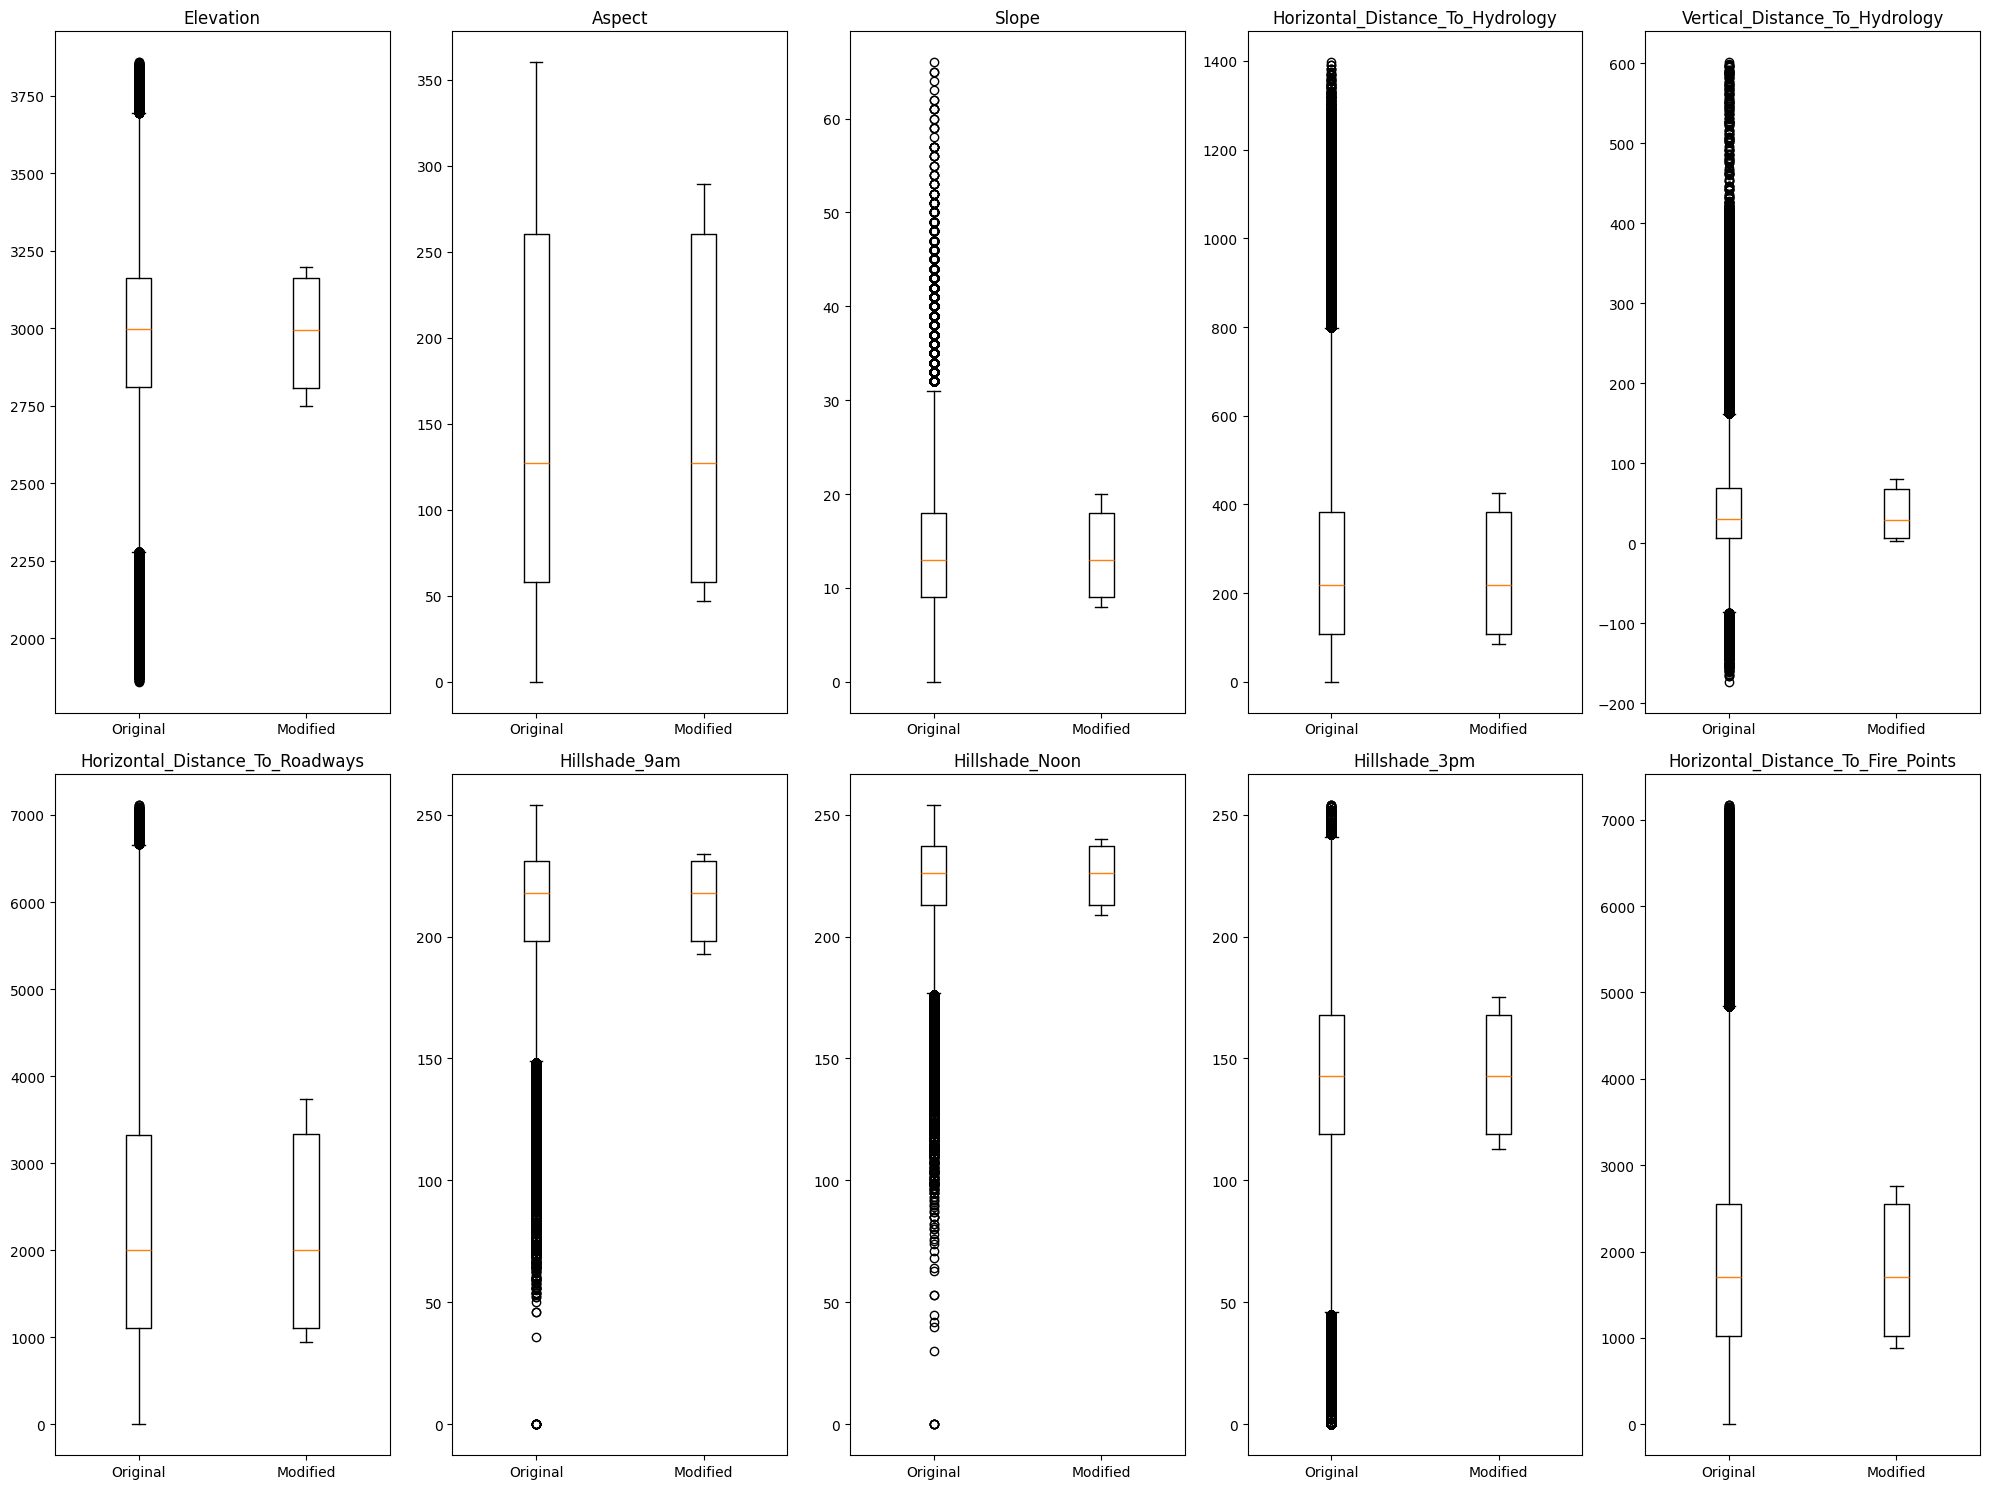

In [28]:
#DELETE
import matplotlib.pyplot as plt

# Set up the figure size
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Plot each column as a boxplot
for i, column in enumerate(X.columns[:10]):
    if i < len(axes):  # Ensure we don't exceed the number of axes
        axes[i].boxplot([X[column], df[column]], tick_labels=['Original', 'Modified'])
        axes[i].set_title(column)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

The whiskers have grown shorter. This is normal, but it does show an important effect. Let's focus on 2 columns, Vertical_Distance_To_Hydrology and Horizontal_Distance_To_Roadways. We'll start with the first, plotting the values from X and df in a histogram together.

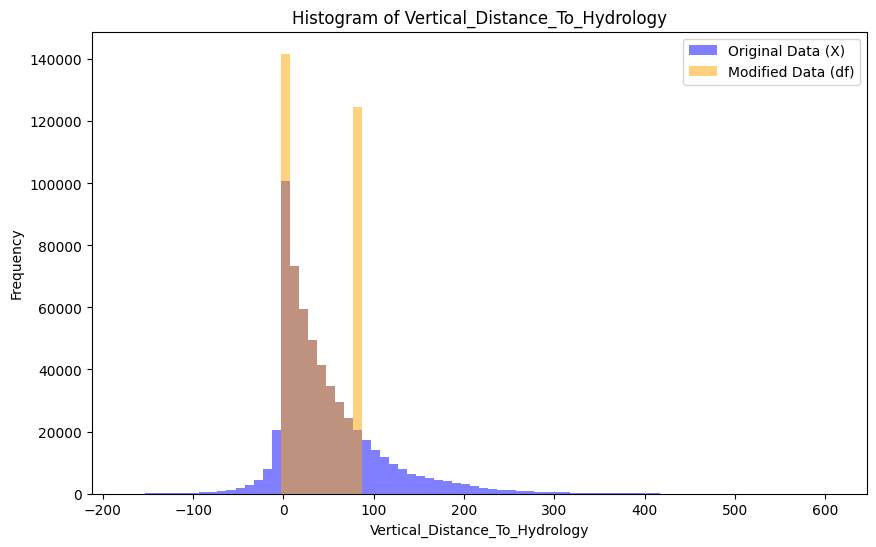

In [29]:
import matplotlib.pyplot as plt

# Plot histogram for "Vertical_Distance_To_Hydrology" from X and df
plt.figure(figsize=(10, 6))
bin_size = 10
min_value = min(X["Vertical_Distance_To_Hydrology"].min(), df["Vertical_Distance_To_Hydrology"].min())
max_value = max(X["Vertical_Distance_To_Hydrology"].max(), df["Vertical_Distance_To_Hydrology"].max())
bins = range(int(min_value), int(max_value) + bin_size, bin_size)

plt.hist(X["Vertical_Distance_To_Hydrology"], bins=bins, alpha=0.5, label="Original Data (X)", color='blue')
plt.hist(df["Vertical_Distance_To_Hydrology"], bins=bins, alpha=0.5, label="Modified Data (df)", color='orange')

# Add labels, title, and legend
plt.xlabel("Vertical_Distance_To_Hydrology")
plt.ylabel("Frequency")
plt.title("Histogram of Vertical_Distance_To_Hydrology")
plt.legend()

# Show the plot
plt.show()

And now Horizontal_Distance_To_Roadways.

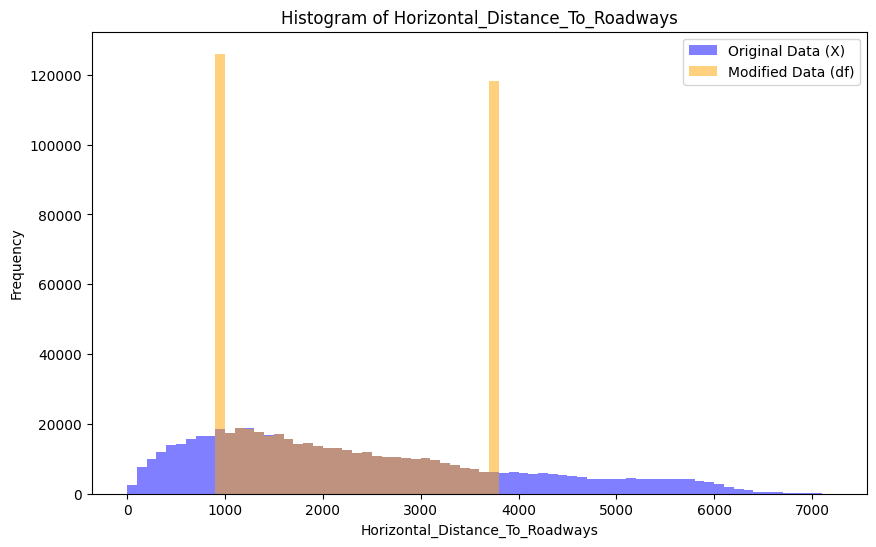

In [30]:
import matplotlib.pyplot as plt

# Plot histogram for "Horizontal_Distance_To_Roadways" from X and df
plt.figure(figsize=(10, 6))
bin_size = 100
min_value = min(X["Horizontal_Distance_To_Roadways"].min(), df["Horizontal_Distance_To_Roadways"].min())
max_value = max(X["Horizontal_Distance_To_Roadways"].max(), df["Horizontal_Distance_To_Roadways"].max())
bins = range(int(min_value), int(max_value) + bin_size, bin_size)

plt.hist(X["Horizontal_Distance_To_Roadways"], bins=bins, alpha=0.5, label="Original Data (X)", color='blue')
plt.hist(df["Horizontal_Distance_To_Roadways"], bins=bins, alpha=0.5, label="Modified Data (df)", color='orange')

# Add labels, title, and legend
plt.xlabel("Horizontal_Distance_To_Roadways")
plt.ylabel("Frequency")
plt.title("Histogram of Horizontal_Distance_To_Roadways")
plt.legend()

# Show the plot
plt.show()

These fields were chosen because the first lost a lot of data to 3\*IQR, the second because it lost none. But the effect of clipping is very obvious: we're introducing giant spikes at the end of the orange spectrum. That means we've been clipping way to aggressively. There shouldn't be any visible spikes here. In fact, the guidelines are:

| Percentile range | Portion modified | Correct description     |
| ---------------- | ---------------- | ----------------------- |
| 0.5%–99.5%       | 1%               | Conservative            |
| 1%–99%           | 2%               | Mild                    |
| 2.5%–97.5%       | 5%               | Moderate/Aggressive     |
| 5%–95%           | 10%              | Very aggressive         |


Let's try again with the conservative .5% without deleting the extremes first.

In [31]:
#DELETE
# Run to restore the data
df = X.copy()
df['target'] = y

for column in df.columns[:10]:
    low, high = df[column].quantile([0.005, 0.995])
    
    df[column] = df[column].clip(lower=low, upper=high)
    

And the graph for Vertical_Distance_To_Hydrology?

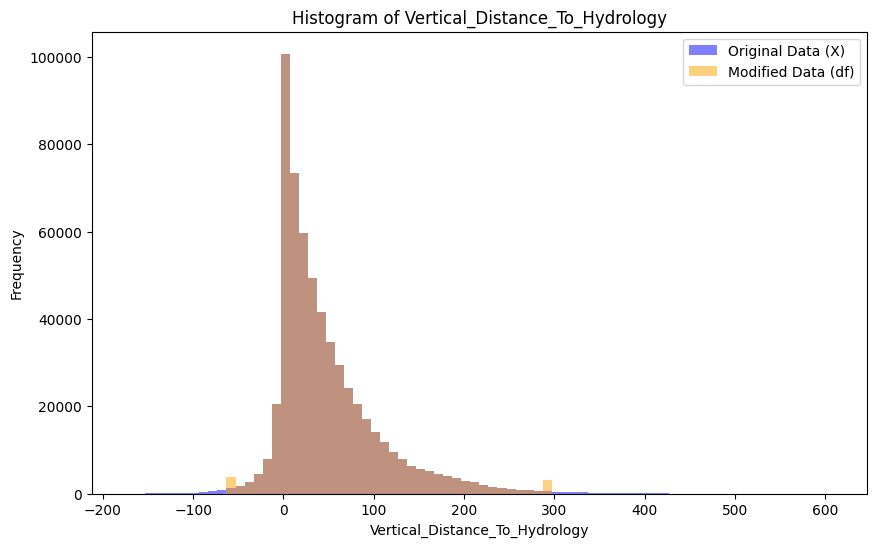

In [32]:
import matplotlib.pyplot as plt

# Plot histogram for "Vertical_Distance_To_Hydrology" from X and df
plt.figure(figsize=(10, 6))
bin_size = 10
min_value = min(X["Vertical_Distance_To_Hydrology"].min(), df["Vertical_Distance_To_Hydrology"].min())
max_value = max(X["Vertical_Distance_To_Hydrology"].max(), df["Vertical_Distance_To_Hydrology"].max())
bins = range(int(min_value), int(max_value) + bin_size, bin_size)

plt.hist(X["Vertical_Distance_To_Hydrology"], bins=bins, alpha=0.5, label="Original Data (X)", color='blue')
plt.hist(df["Vertical_Distance_To_Hydrology"], bins=bins, alpha=0.5, label="Modified Data (df)", color='orange')

# Add labels, title, and legend
plt.xlabel("Vertical_Distance_To_Hydrology")
plt.ylabel("Frequency")
plt.title("Histogram of Vertical_Distance_To_Hydrology")
plt.legend()

# Show the plot
plt.show()

Way better. Still some spikes, but at the very least they're not higher than the data anymore. The other graph?

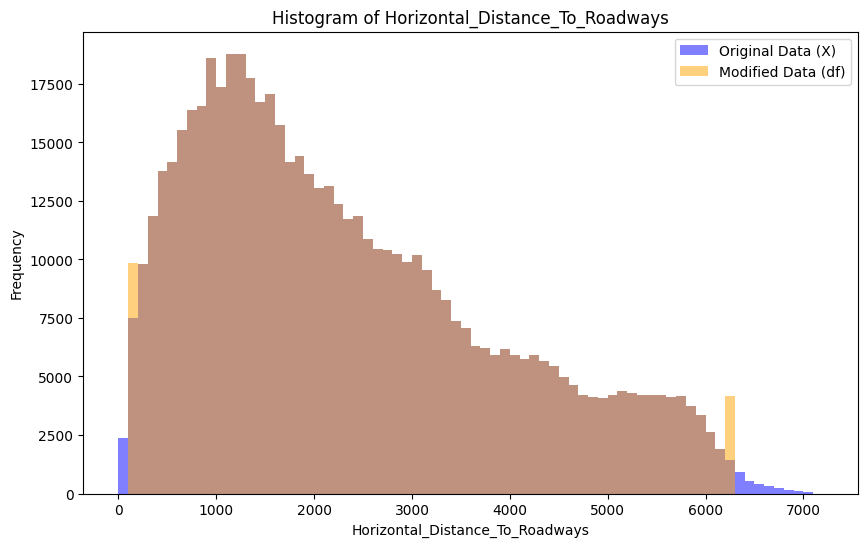

In [33]:
import matplotlib.pyplot as plt

# Plot histogram for "Horizontal_Distance_To_Roadways" from X and df
plt.figure(figsize=(10, 6))
bin_size = 100
min_value = min(X["Horizontal_Distance_To_Roadways"].min(), df["Horizontal_Distance_To_Roadways"].min())
max_value = max(X["Horizontal_Distance_To_Roadways"].max(), df["Horizontal_Distance_To_Roadways"].max())
bins = range(int(min_value), int(max_value) + bin_size, bin_size)

plt.hist(X["Horizontal_Distance_To_Roadways"], bins=bins, alpha=0.5, label="Original Data (X)", color='blue')
plt.hist(df["Horizontal_Distance_To_Roadways"], bins=bins, alpha=0.5, label="Modified Data (df)", color='orange')

# Add labels, title, and legend
plt.xlabel("Horizontal_Distance_To_Roadways")
plt.ylabel("Frequency")
plt.title("Histogram of Horizontal_Distance_To_Roadways")
plt.legend()

# Show the plot
plt.show()

So to conclude: when clipping (or doing winsorzation), keep it chill.